# Data Analysis and Processing on AWS

In this lab, we will explore how to analyze dataset using available Python packages as well as performing data processing using AWS services. These tasks are typically pre-requisites for you to start training your ML model.

## Dataset
For purpose of this lab, we'll use publicly available data [NYC Taxi and Limousine Trips](https://registry.opendata.aws/nyc-tlc-trip-records-pds/). As name tells, this dataset captures trip records by various transportation vendors (Yellow cab, Green cab, Uber ) in 2010s. The dataset is used extensively to analyze transportation patterns in NYC. Full documentation about

As different transportation vendors report their trip in different formats, we'll pick Green Cab taxi service for data consistency.


# Data Exploration with AWS Data Wrangler

[AWS Data Wrangler](https://aws-data-wrangler.readthedocs.io/en/latest/what.html) is an open-source Python package that extends the power of Pandas library to AWS connecting DataFrames and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc). Built on top of other open-source projects like Pandas, Apache Arrow, Boto3, s3fs, SQLAlchemy, Psycopg2 and PyMySQL, it offers abstracted functions to execute usual ETL tasks like load/unload data from Data Lakes, Data Warehouses and Databases.

In this lab, we'll use Data Wrangler to do ad-hoc analysis of dataset and relation between features in given dataset.

To start working with Data Wrangler, we need to install it first via Python PIP package manager.

In [ ]:
! pip install awswrangler

In [23]:
import awswrangler as wr
import boto3

In [40]:
def list_bucket_contents(bucket_resource, match='', size_mb=0):
    """
    This function list all objects in given bucket which
    matches specific name pattern and are bigger than defined 
    object size.
    """
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    objects = []
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True

        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
            objects.append(f"s3://{bucket_resource.name}/{key.key}")            
            
        elif list_check and key_size_mb >= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            objects.append(f"s3://{bucket_resource.name}/{key.key}")
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket_resource.name} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')
    return objects

In [ ]:
taxi_s3_bucket = "nyc-tlc" # public S3 bucket

# Let's create S3 bucket object which we'll use to up
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')
taxi_bucket = s3_resource.Bucket(taxi_s3_bucket)

# select all files with matching having "trip data" in S3 key and bigger than 1MB
objects = list_bucket_contents(taxi_bucket, match="green", size_mb=100)

In [44]:
# We'll pick first object
idx=0

# Need to properly capture dataframe object
dfcolumns = wr.s3.read_csv(objects[idx], nrows=1)

# This method allows to fetch seamless S3 object to your
# notebook memory and then work object using Pandas API
df = wr.s3.read_csv(objects[idx],
                  header = None,
                  skiprows = 1,
                  usecols = list(range(len(dfcolumns.columns))),
                  names = dfcolumns.columns)

In [ ]:
# This allows us to preview first 20 records in the dataset
df.head(20)

In [46]:
# Now, let's check math statistics of individual records: mean, count, min, max etc.
df.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,Total_amount,Payment_type,Trip_type
count,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,1.005242e+06,0.0,1.005242e+06,1.005242e+06,407433.000000
mean,1.768943e+00,1.102940e+00,-7.380195e+01,4.069554e+01,-7.379725e+01,4.068985e+01,1.432812e+00,2.811993e+00,1.201771e+01,3.642371e-01,4.909092e-01,8.926305e-01,9.236801e-02,NaN,1.385818e+01,1.655208e+00,1.000488
std,4.215089e-01,6.708065e-01,3.062802e+00,1.688734e+00,3.123370e+00,1.722940e+00,1.140592e+00,2.797299e+00,1.003236e+01,6.392270e-01,6.687848e-02,1.955508e+00,1.339052e+00,NaN,1.115447e+01,4.934052e-01,0.022095
min,1.000000e+00,1.000000e+00,-7.548545e+01,0.000000e+00,-7.598902e+01,0.000000e+00,0.000000e+00,0.000000e+00,-8.500000e+00,0.000000e+00,-5.000000e-01,0.000000e+00,0.000000e+00,NaN,-9.000000e+00,1.000000e+00,1.000000
25%,2.000000e+00,1.000000e+00,-7.395595e+01,4.071794e+01,-7.396205e+01,4.072002e+01,1.000000e+00,1.060000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,NaN,7.500000e+00,1.000000e+00,1.000000
50%,2.000000e+00,1.000000e+00,-7.394003e+01,4.076161e+01,-7.393970e+01,4.076070e+01,1.000000e+00,1.900000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,NaN,1.070000e+01,2.000000e+00,1.000000
75%,2.000000e+00,1.000000e+00,-7.390532e+01,4.081029e+01,-7.390157e+01,4.080867e+01,1.000000e+00,3.610000e+00,1.500000e+01,5.000000e-01,5.000000e-01,1.300000e+00,0.000000e+00,NaN,1.700000e+01,2.000000e+00,1.000000
max,2.000000e+00,9.900000e+01,0.000000e+00,4.235678e+01,0.000000e+00,4.158552e+01,9.000000e+00,1.352400e+02,4.543000e+03,4.843100e+02,1.500000e+00,2.226700e+02,7.500000e+02,NaN,4.543000e+03,5.000000e+00,2.000000


In [30]:
# Will remove columns which are doesn't have meaningful information
df = df.drop(["Store_and_fwd_flag", "Ehail_fee", "Trip_type ", "RateCodeID", "Payment_type"], axis=1)


## Visualizing trips geography

As we have coordinates (latitude & longitude), let's try see if we can understand where our passengers are being pickedup and dropped off.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline

color = sns.color_palette()

Text(0.5, 1.0, 'Dropoff Location')

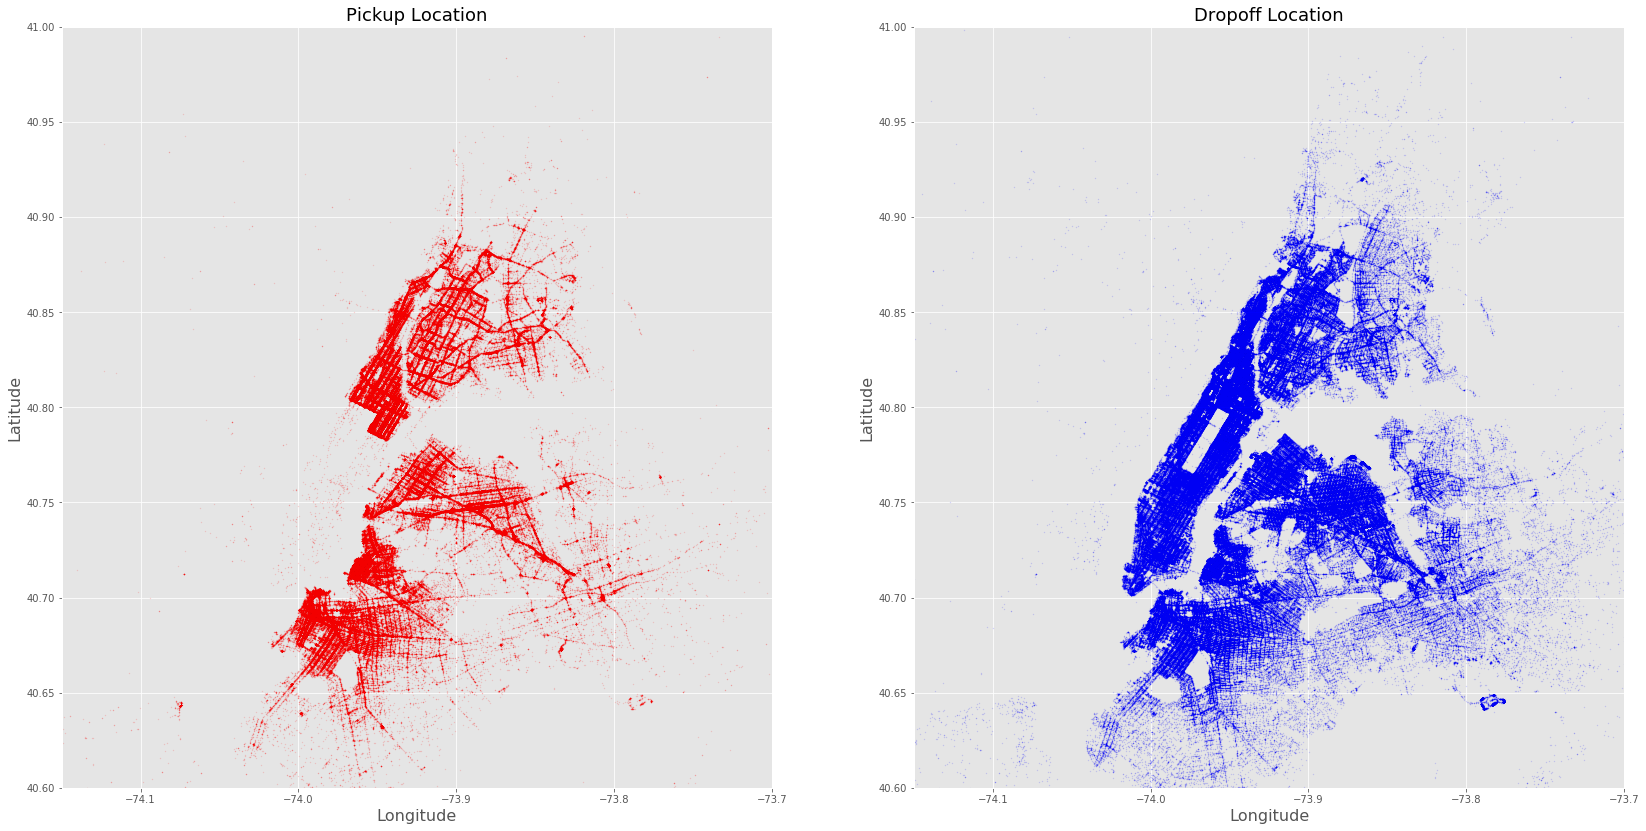

In [49]:
fig = plt.figure(figsize=(28,14))
ax1 = fig.add_subplot(121)
ax1.scatter(df.Pickup_longitude,
            df.Pickup_latitude,
            s=1,alpha=0.1,color='red')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=18)

ax1 = fig.add_subplot(122)
ax1.scatter(df.Dropoff_longitude,
            df.Dropoff_latitude,
            s=1,alpha=0.1,color='blue')

plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Dropoff Location',fontsize=18)

### Data Observations
As expected we can see that Manhattan and Downtown Brooklyn are most popular locations for both pickup and dropoff. It's the most dense areas in NYC in terms of population. We can also speculate as these areas has highest real estate prices, so people who live there have means to use cabs frequently.  Another area popular area on the map is JFK airport (bottom right corner).

It's also clear that our chosen Green Can vendor is rarely picking up people in Manhattan Midtown and Downtown. Most likely this is because of either because of specifics of their license or deliberate market segmentation between different Taxi vendors. 

### Analyze Correlation Between Features

As a next step, let's review how different features correlate between each other. For this, we'll print correlation plot for all features in our dataset. Correlation allows us to establish level of interdependency between two random variables. Correlation coefficient belongs to [-1, 1] interval, where "-1" indicates inverse relation between variables and "1" direct direct relationship. Note, correlation doesn't imply causation.  See more details on correlation [here](https://en.wikipedia.org/wiki/Correlation_and_dependence).

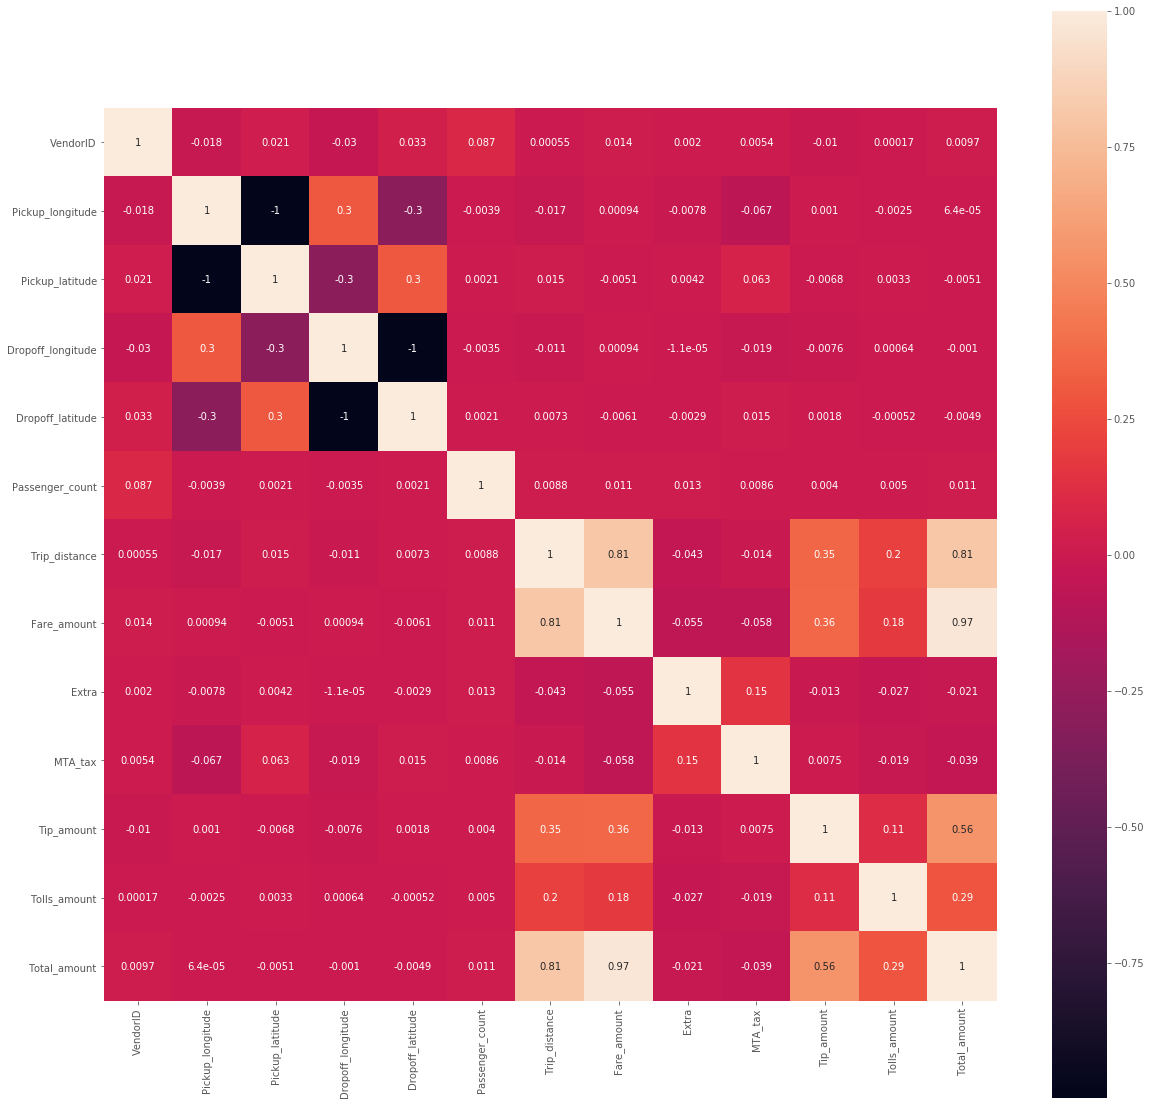

In [33]:
numtrain = df.select_dtypes(include=[np.number])
corr = numtrain.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,vmax=1,square=True,annot=True)

### Data Observations

We can confirm several expected trends in the data:
- strongest positive correlation is between trip distance and total amount paid;
- Tolls and rates are correlated with location features (latitudes and longitudes);
- There are a medium-to-weak correlations between latitudes and longitudes which can be explained by goagraphical positioning of most dense areas of NYC.


# Data Engineering at Scale with Sagemaker Processing

In order to prepare dataset for ML model, typically we will need to perform following data engineering operations:
- drop columns which doesn't present interest and records with empty values;
- standartize numerical features (i.e. float or integer data points);
- one-hot encode categorical features.


### Standarization of numerical features

Standartization is a frequent step in data processing and feature engineering. The goal of this process is to ensure that all numerical features have the same scale and their values are concentrated on [-1; 1] interval. Without standartization, many algorithms may be numerically unstable and influence. See more details on standartization in [this wiki article](https://en.wikipedia.org/wiki/Feature_scaling).

**Question**: can you name numerical feature in the NYC Taxi dataset?


### One-hot encoding of categorical features

Categorical features in ML terms are non-numerical features which represent possible classes of given variable. Let's take as an example a categorical feature `color` with possible values of "red", "green", and "blue". Without modifications, `color` variable won't be useful for most of ML algorithms as they won't be able to handle it properly. One-hot encoding allows you to convert categorical feature into set of numerical features, so your ML algorithm can use these feature during training process. 

Here is an example of one-hot encoding for `color` variable:
1. Takes original `color` feature;
2. For each possible color value creates a new feature, total number of new features are equal to number of possible values in original `color` feature;
3. Assign "0" and "1" to new features based on value from `color`, where "1" is assigned when value in `color` matches derived column.

<img src="images/onehot.png" width=600/>


### Wrapping up - upload data to private S3 bucket

Now, let's upload all data files related to Greencab Taxi rides to your private S3 bucket.

In [25]:
%time
from sagemaker import Session

# Default bucket which will be used by Sagemaker later in the lab
bucket = sagemaker.Session().default_bucket()
# Constructing S3 path to upload Greencab Taxi dataset
taxi_s3_path = f"s3://{bucket}/taxi_data"

# "!" executes command line, in the case we are using AWS CLI utility to copy object from public bucket to your private
!aws s3 cp "s3://nyc-tlc/trip data/" $taxi_s3_path --recursive --exclude "*" --include "*green_tripdata_2014*"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
copy: s3://nyc-tlc/trip data/green_tripdata_2014-01.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-01.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-02.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-02.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-03.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-03.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-04.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-04.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-05.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-05.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-06.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-06.csv
copy: s3://nyc-tlc/trip data/green_tripdata_2014-07.csv to s3://sagemaker-us-east-2-553020858742/taxi_data/green_tripdata_2014-07.cs


## Sagemaker Processing

In case of NYC Taxi dataset, we have 36 files for Green Cab vendor with total size of ~8GB. If we wish to handle all files in NYC Taxi dataset, we'd need to handle ~300Gb. Running processing in such sizeable datasets on local box will take considerable time.

However, this is a perfect use case for Sagemaker Processing!

With Amazon SageMaker Processing jobs, you can leverage a simplified, managed experience to run data pre- or post-processing and model evaluation workloads on the Amazon SageMaker platform. A processing job downloads input from Amazon Simple Storage Service (Amazon S3), then uploads outputs to Amazon S3 during or after the processing job.

<img src="images/proc_1.jpg"/>


## Leveraging Scikit-learn for data processing
[Scikit-learn](https://scikit-learn.org/stable/) is industry standard Python package for Machine Learning. It also provides a number of feature to perform data processing. We'll use available implementations for data standartization 


In [28]:
import boto3
import sagemaker
from sagemaker import get_execution_role, Session
from sagemaker.sklearn.processing import SKLearnProcessor

region = boto3.session.Session().region_name

role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.xlarge',
                                     instance_count=2)

In [ ]:
! pygmentize feature_processing.py

In [77]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor.run(code='feature_processing.py', 

                      inputs=[ProcessingInput(source=taxi_s3_path, destination='/opt/ml/processing/input/data', 
                                              s3_data_distribution_type='ShardedByS3Key')],                      
                      outputs=[ProcessingOutput(output_name='processed_data',
                                                source='/opt/ml/processing/output/data')],
                     )

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs

Job Name:  sagemaker-scikit-learn-2020-07-28-15-36-15-224
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-553020858742/taxi_data', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-553020858742/sagemaker-scikit-learn-2020-07-28-15-36-15-224/input/code/feature_processing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'processed_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-553020858742/sagemaker-scikit-learn-2020-07-28-15-36-15-224/output/processed_data', 'LocalPath': '/opt/ml/processing/output/data', 'S3UploadMode': 'EndOfJob'}}]
............

In [64]:
# Let's confirm that our processed files where automatically uploaded to destination S3 bucket

preprocessing_job_description = sklearn_processor.jobs[-1].describe()
output_config = preprocessing_job_description['ProcessingOutputConfig']
s3_output_path = output_config['Outputs'][0]['S3Output']['S3Uri']

! aws s3 ls $s3_output_path --recursive

2020-07-28 15:26:44  124204550 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-01.csv
2020-07-28 15:26:49  155079127 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-02.csv
2020-07-28 15:26:44  199608246 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-03.csv
2020-07-28 15:26:49  200218030 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-04.csv
2020-07-28 15:26:44  218826062 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-05.csv
2020-07-28 15:26:49  191303720 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-06.csv
2020-07-28 15:26:44  195014206 sagemaker-scikit-learn-2020-07-28-15-20-52-927/output/processed_data/processed_green_tripdata_2014-07.csv
2020-07-28 15:26:49  207028160 sagemaker-

### Compare processed results with initial 

Let's now compare how data processing changes the underlying statistics of the dataset. For this, we'll take `total_amount` feature from one of original files and from processed files. Then, we'll print its univariate distribution and compare it.

In [78]:
file = "green_tripdata_2014-01.csv"

original_s3_path = f"s3://nyc-tlc/trip data/{file}"
processed_s3_path = f"{s3_output_path}/processed_{file}"

Let's compare initial dataset to processed dataset. 

### Check that numeric features were standartized as expected.

For this, we'll take `Trip_distance` feature and compare boxplots in original dataset and processed dataset. Note, how ranges of values changed.

In [80]:
dfcolumns = wr.s3.read_csv(original_s3_path, nrows=1)

# Fetch object from S3 to memory
original_df = wr.s3.read_csv(original_s3_path,
                  header = None,
                  skiprows = 1,
                  usecols = list(range(len(dfcolumns.columns))),
                  names = dfcolumns.columns)

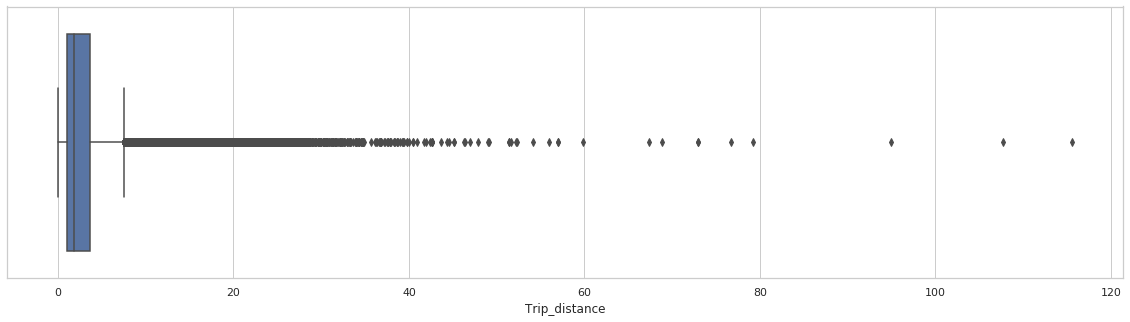

In [81]:
# sns.distplot(original_df.Total_amount, hist=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
# dataset = sns.load_dataset(original_df)
ax = sns.boxplot(x=original_df["Trip_distance"])

In [84]:
dfcolumns = wr.s3.read_csv(processed_s3_path, nrows=1)

# Fetch object from S3 to memory
processed_df = wr.s3.read_csv(processed_s3_path,
                  header = None,
                  skiprows = 1,
                  usecols = list(range(len(dfcolumns.columns))),
                  names = dfcolumns.columns)

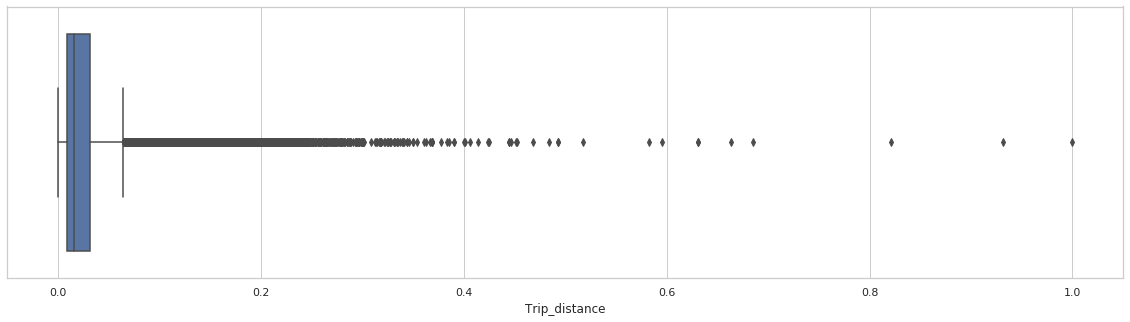

In [94]:
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
ax = sns.boxplot(x=processed_df["Trip_distance"])

### Check that features where one-hot encoded

In our processing script we identified single feature `VendorID` as one appropriate for one-hot encoding procedure. Let's confirm that this operations was performed as expected.

In [99]:
# Categorical feature in original dataset
original_df[["VendorID"]].tail(20)

,VendorID
803832,1
803833,2
803834,2
803835,1
803836,2
803837,2
803838,2
803839,2
803840,1
803841,2


In [98]:
# One-hot encoded features in processed dataset
processed_df[["Vendor_1", "Vendor_2"]].tail(20)

,Vendor_1,Vendor_2
803832,1.0,0.0
803833,0.0,1.0
803834,0.0,1.0
803835,1.0,0.0
803836,0.0,1.0
803837,0.0,1.0
803838,0.0,1.0
803839,0.0,1.0
803840,1.0,0.0
803841,0.0,1.0
